In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt


from lstm import Gated_LSTM, lr_dict_scheduler, make_step
from data import DataLoader, normalize_data

# Params
feature_labels = ['Q','SSC']
target_label = 'SSC'
split_date = '2018-01-01'
num_samples = 5000
sequence_length = 30
batch_size = 64
num_epochs = 30
max_grad_norm = 1
hidden_size=16

lr_schedule = {
    0: 0.01, 
    10: 0.005, 
    20: 0.001}

feature_size = len(feature_labels)
output_size = 1

data = pd.read_parquet("../data/synthetic_daily.parquet", engine='pyarrow')

# Split the dataset into training and testing sets based on the fixed date
train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]

# Normalize the training and testing data separately
train_norm, scale = normalize_data(train_data)
test_norm, _ = normalize_data(test_data, scale=scale)

def irregular_sample(df, percent_obs, cols):
    df = df.copy() # Deep copy
    for col in cols:
        mask = np.random.rand(len(df)) < percent_obs
        df.loc[mask, col] = np.nan
    return df
    
# Split the features and targets
train_features = irregular_sample(train_norm[feature_labels],0.95,["SSC"]).values
test_features = irregular_sample(test_norm[feature_labels],0.95,["SSC"]).values
train_targets = train_norm[target_label].values
test_targets = test_norm[target_label].values

# Create batch generators 
train_dataloader_gen = DataLoader((train_features, train_targets), 
                                  batch_size, 
                                  sequence_length, 
                                  fill_and_weight=True)

test_dataloader_gen = DataLoader((test_features, test_targets), 
                                 batch_size, 
                                 sequence_length, 
                                 fill_and_weight=True, 
                                 shuffle=False)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

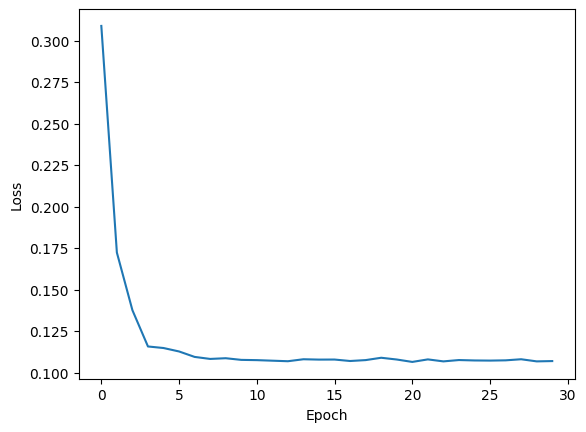

In [2]:
# Initialize the model
key = jax.random.PRNGKey(0)
model = Gated_LSTM(in_size=feature_size, 
                 out_size=output_size, 
                 hidden_size=hidden_size, 
                 key=key)

# Initialize optimizer 
current_lr = lr_dict_scheduler(0, lr_schedule)
optim = optax.adam(current_lr)
opt_state = optim.init(model)

# Training loop
loss_list = []
pbar = trange(num_epochs, desc="Epoch")
for epoch in pbar:
    current_lr = lr_dict_scheduler(epoch, lr_schedule)
    optim = optax.adam(current_lr)
    
    total_loss = 0
    num_batches = 0
    for x_batch, w_batch, y_batch in train_dataloader_gen:
        #What if instead we set the weights to 0 for only the bad columns? 
        #Would need to replace the data in x_batch too, but can be 0s since it will be fully gated.
        bad_batches = np.any(np.any(np.isnan(x_batch), axis=1),axis=1)
        if all(bad_batches):
            continue
        x_batch = x_batch[~bad_batches,:,:]
        w_batch = w_batch[~bad_batches,:,:]
        y_batch = y_batch[~bad_batches,:]
        
        loss, model, opt_state = make_step(model, x_batch, w_batch, y_batch, opt_state, optim, max_grad_norm)
        total_loss += loss
        num_batches += 1
        if num_batches * batch_size >= num_samples:
            break
    current_loss = total_loss / num_batches
    loss_list.append(current_loss)
    pbar.set_postfix_str(f"Loss: {current_loss:.4f}")

plt.close()
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [3]:
# Initialize lists to store predictions and true values
predictions = []

# Iterate over the test data
for x_batch, w_batch, y_batch in tqdm(test_dataloader_gen):
    # Make predictions for the current batch
    pred = jax.vmap(model)((x_batch, w_batch))
    predictions.extend(pred)

# # Convert lists to arrays
predictions = np.array(predictions).flatten()

rescaled_pred = predictions * scale['std'][target_label] + scale['mean'][target_label]
x_pred = range(sequence_length,len(predictions)+sequence_length)

0it [00:00, ?it/s]

Text(0.5, 1.0, 'Test Data Predictions')

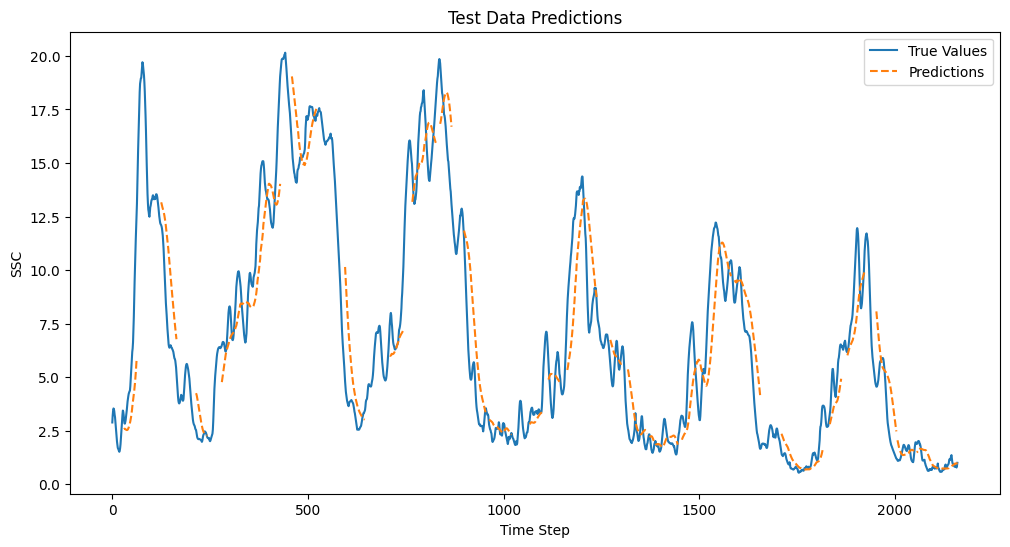

In [4]:
# Plot the true values and predictions
plt.figure(figsize=(12, 6))
# plt.plot(test_features*scale['std']['SSC']+scale['mean']['SSC'], label='Features', linestyle='none',marker='o')
test_data.reset_index()[target_label].plot(label='True Values')
plt.plot(x_pred, rescaled_pred, label='Predictions', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel(target_label)
plt.legend()
plt.title('Test Data Predictions')